### Clustering and Subsampling 

In [1]:
%config InlineBackend.figure_formats = ['png2x']  # set to svg for vector graphics quality
import scanpy.api as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl
from collections import OrderedDict
from sklearn import metrics

sc.settings.verbosity = 0
sc.settings.set_dpi(120)
sc.logging.print_version_and_date()

RUN_NAME = 'pbmc8k'
N_GENES = 3000
RESOLUTION = 0.5

Running Scanpy version 0.2.5+9.gf33bd1b on 2017-08-03 12:09.


/home/jovyan/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


* CD3e - pan T cell
* CD8A - CD8 T cell
* CCR7+ - Naive
* S100A4 - memory (is detected with less than one count)

In [143]:
adata = sc.read('../../jamboree/10x_pbmc/counts/from_10x/filtered_gene_bc_matrices/GRCh38/matrix.mtx', cache=True).transpose()
adata.var_names = np.genfromtxt('../../jamboree/10x_pbmc/counts/from_10x/filtered_gene_bc_matrices/GRCh38/genes.tsv', dtype=str)[:, 1]
adata.smp_names = np.genfromtxt('../../jamboree/10x_pbmc/counts/from_10x/filtered_gene_bc_matrices/GRCh38/barcodes.tsv', dtype=str)

In [144]:
sc.pp.recipe_zheng17(adata, n_top_genes=N_GENES)

In [145]:
sc.tl.tsne(adata)

In [146]:
sc.write(RUN_NAME, adata)

In [147]:
sc.read(RUN_NAME)
sc.tl.louvain(adata, resolution=RESOLUTION)

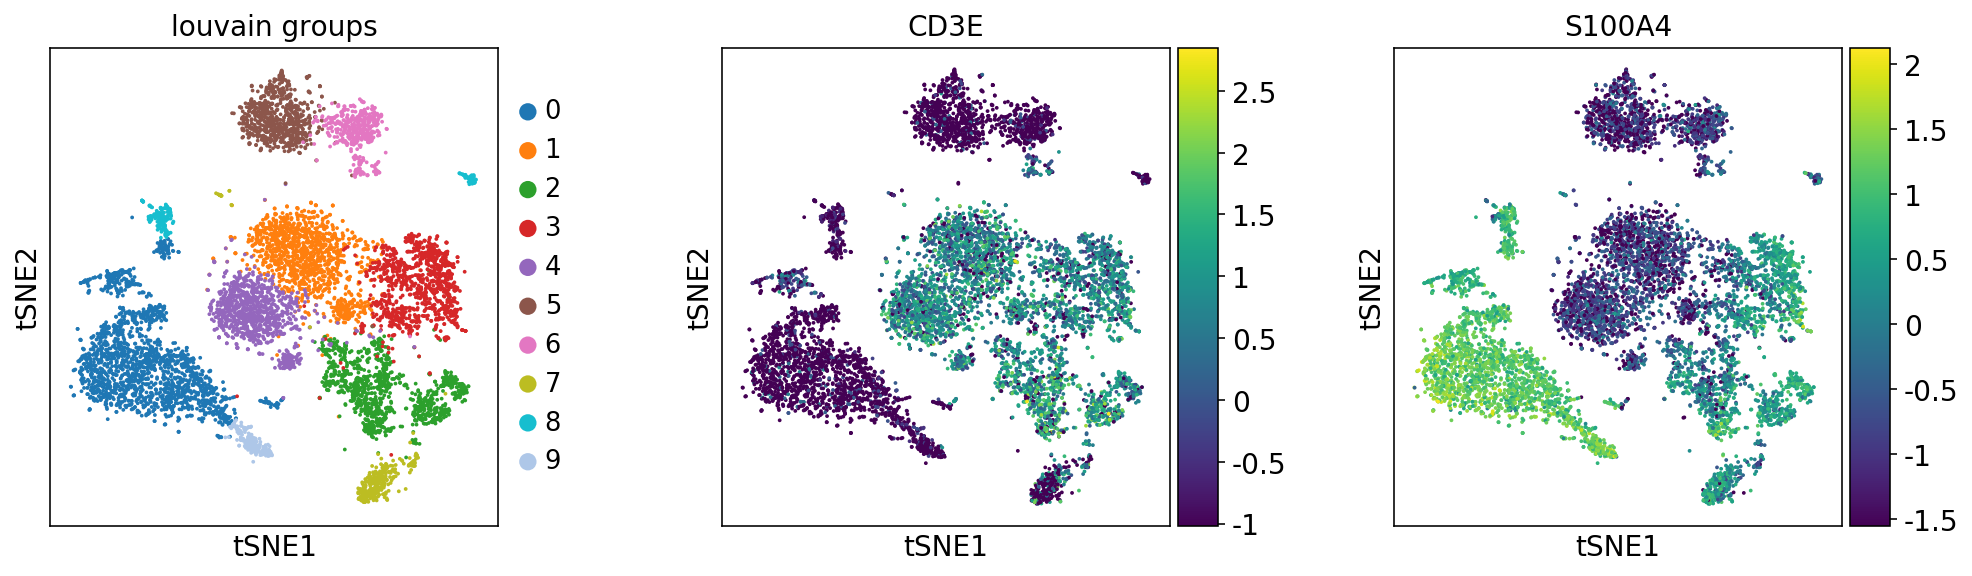

In [170]:
axs = sc.pl.tsne(adata, color=['louvain_groups', 'CD3E', 'S100A4'], color_map='viridis')

In [175]:
sc.write(RUN_NAME, adata)

### Subsampling and reclustering

In [2]:
def compute_score(pred_labels, ref_labels,
                  threshold_overlap_pred=0.5, threshold_overlap_ref=0.5):
    """How well do the pred_labels explain the ref_labels?
    
    A predicted cluster explains a reference cluster if it is contained within the reference 
    cluster with at least 50% (threshold_overlap_pred) of its points and these correspond 
    to at least 50% (threshold_overlap_ref) of the reference cluster.
    """
    ref_unique, ref_counts = np.unique(ref_labels, return_counts=True)
    ref_dict = dict(zip(ref_unique, ref_counts))
    pred_unique, pred_counts = np.unique(pred_labels, return_counts=True)
    pred_dict = dict(zip(pred_unique, pred_counts))
    summary = []
    for true in ref_unique:
        sub_pred_unique, sub_pred_counts = np.unique(pred_labels[true == ref_labels], return_counts=True)
        relative_overlaps_pred = [sub_pred_counts[i] / pred_dict[n] for i, n in enumerate(sub_pred_unique)]
        relative_overlaps_ref = [sub_pred_counts[i] / ref_dict[true] for i, n in enumerate(sub_pred_unique)]        
        pred_best_index = np.argmax(relative_overlaps_pred)
        summary.append(1 if (relative_overlaps_pred[pred_best_index] >= threshold_overlap_pred and
                             relative_overlaps_ref[pred_best_index] >= threshold_overlap_ref)
                       else 0)
        # print(true, sub_pred_unique[pred_best_index], relative_overlaps_pred[pred_best_index],
        #       relative_overlaps_ref[pred_best_index], summary[-1])        
    return sum(summary)/len(summary)

[1, 0.5, 0.2, 0.1, 0.05, 0.01, 1, 1, 1, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01]
1 0.9 / 

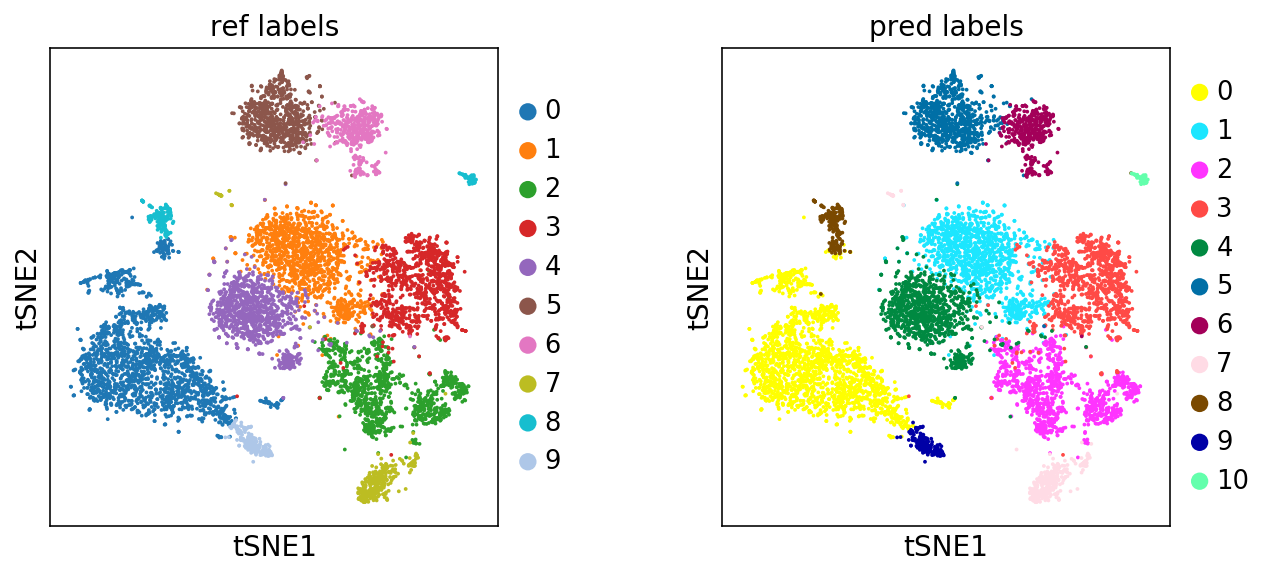

0.5 1.0 / 

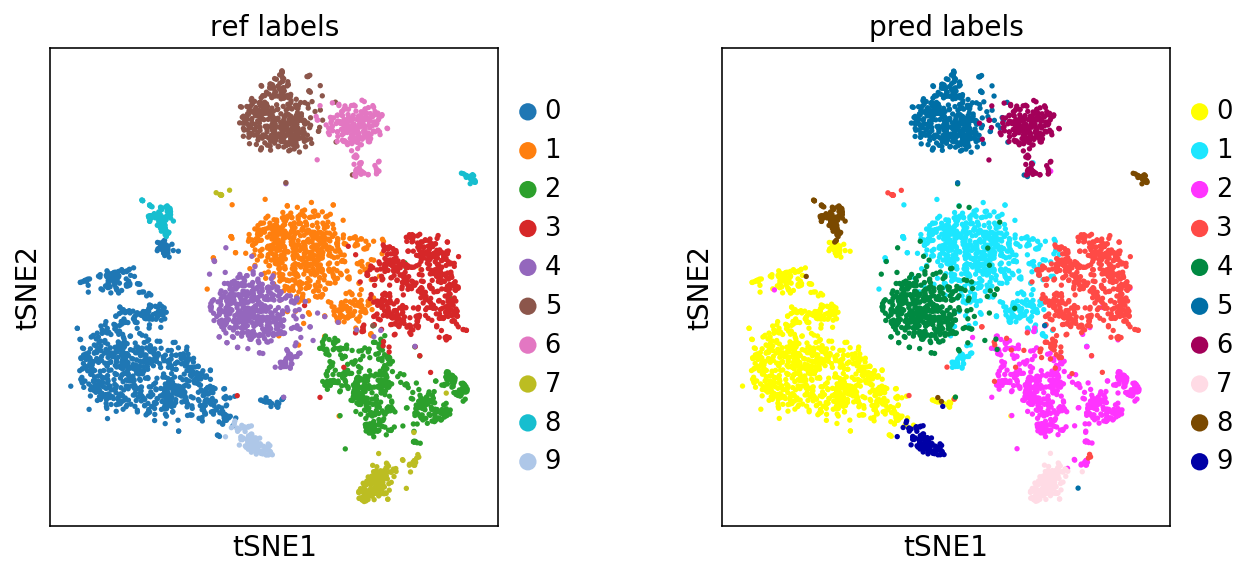

0.2 0.7 / 

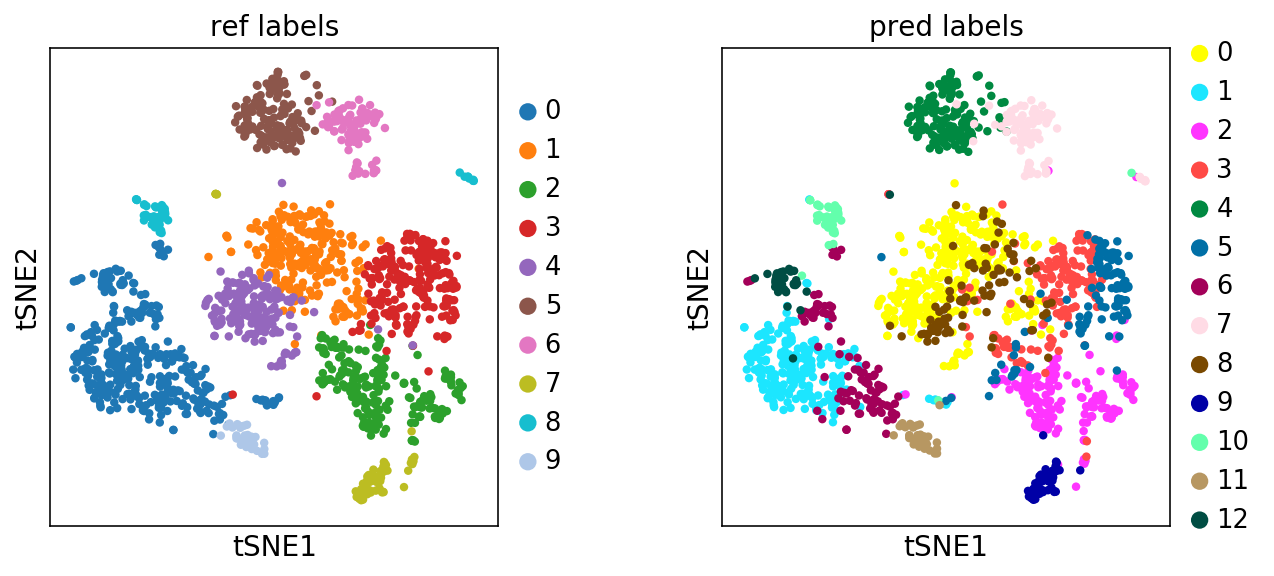

0.1 0.5 / 

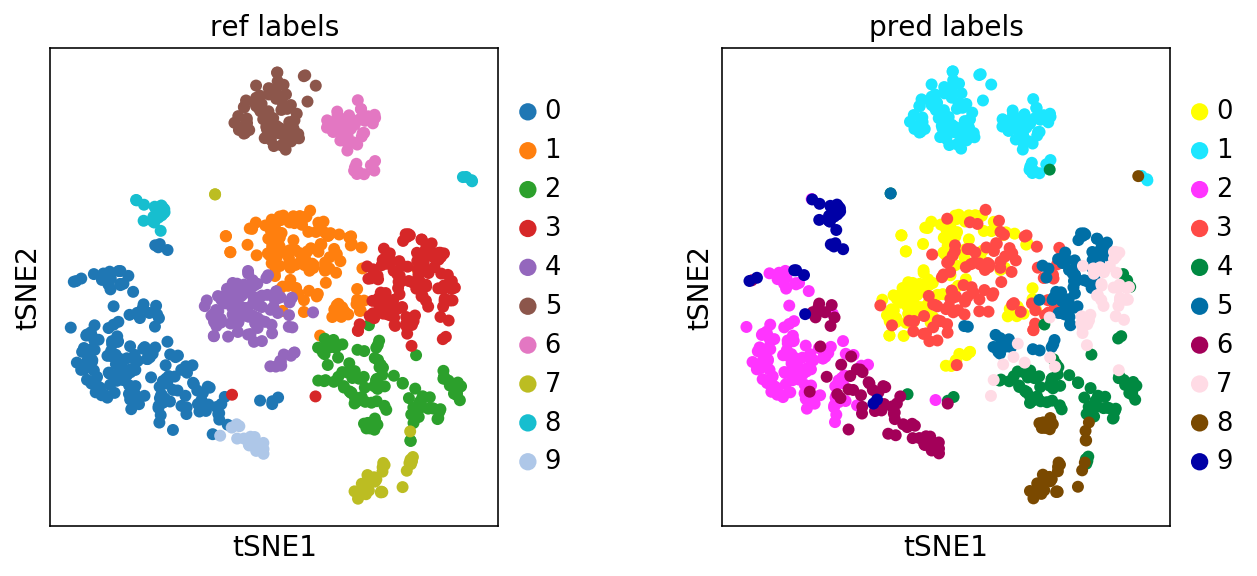

0.05 0.6 / 

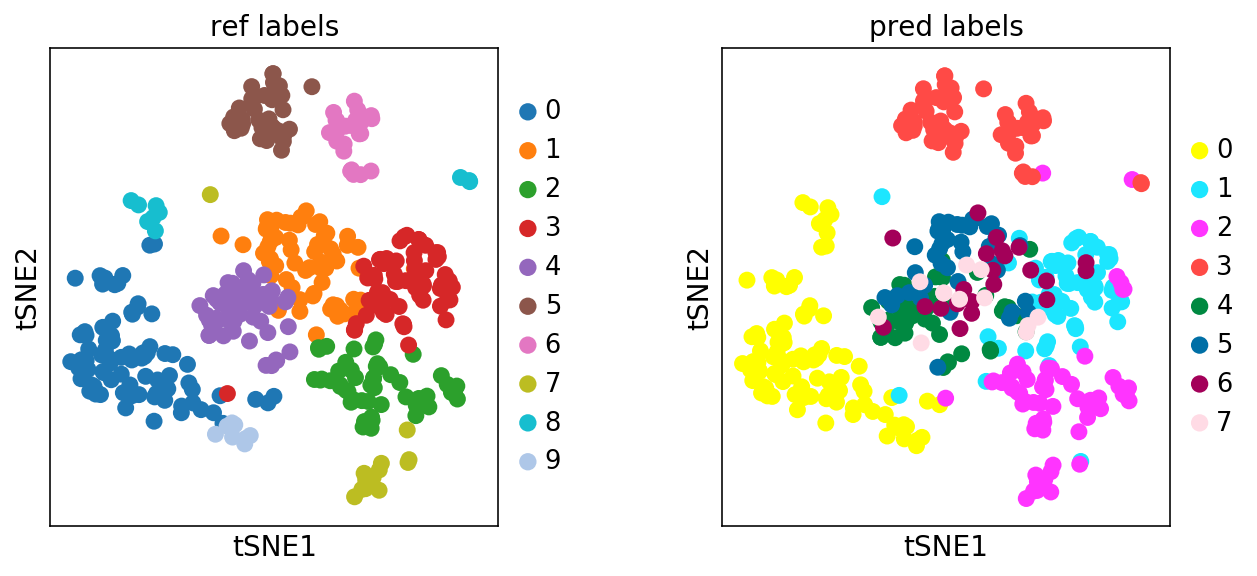

0.01 0.0 / 

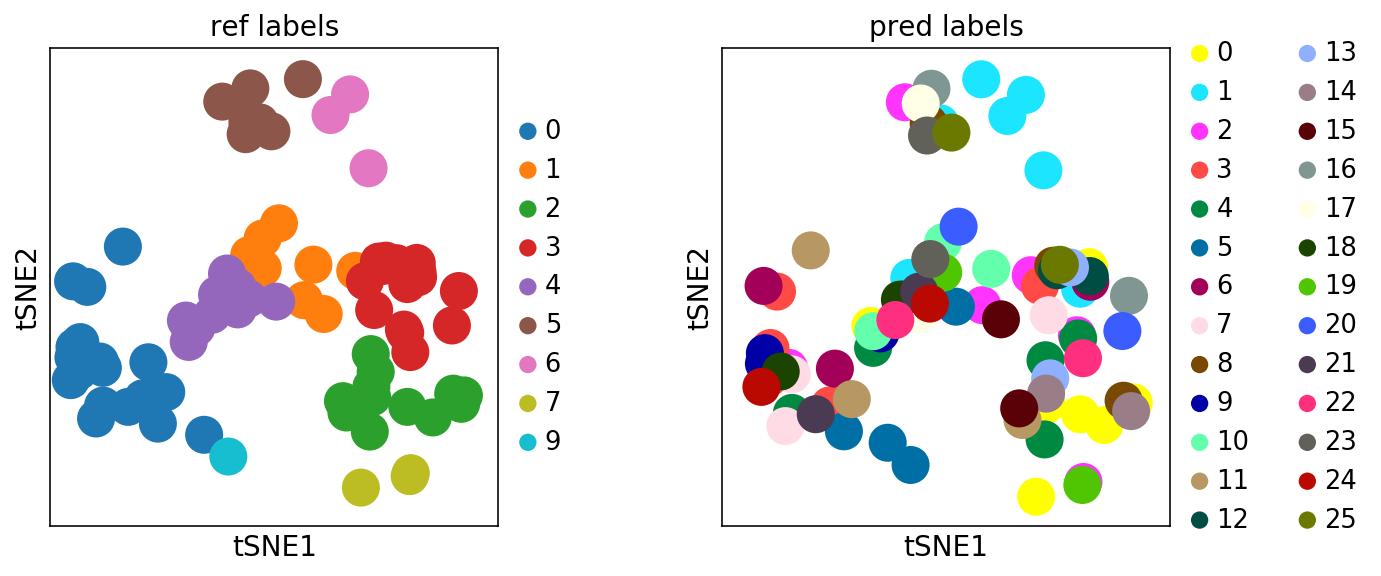

1 1.0 / 1 1.0 / 1 1.0 / 0.5 1.0 / 0.5 1.0 / 0.5 1.0 / 0.2 0.8 / 0.2 0.8 / 0.2 0.6 / 0.1 0.6 / 0.1 0.6 / 0.1 0.4 / 0.05 0.4 / 0.05 0.5 / 0.05 0.4 / 0.01 0.1111111111111111 / 0.01 0.1111111111111111 / 0.01 0.0 / 

In [7]:
adata = sc.read(RUN_NAME)
fractions_examples = [1, 0.5, 0.2, 0.1, 0.05, 0.01]
fractions = fractions_examples + [f for f in fractions_examples for repeat in range(3)]
print(fractions)
scores = []
scores_rand = []
sc.settings.verbosity = 0
for ifraction, fraction in enumerate(fractions):
    _, smp_indices = sc.pp.subsample(adata.X, fraction=fraction)
    adata_sub = adata[smp_indices]
    ref_labels = adata.smp['louvain_groups'][smp_indices]
    resolution = RESOLUTION
    # try adjusting the resolution so that the number of clusters 
    # is at least as high as in the reference
    for iter_resolution in range(10):
        sc.tl.louvain(adata_sub,
                      resolution=resolution,
                      recompute_pca=True,
                      recompute_graph=True)
        if (len(adata_sub.add['louvain_groups_names']) 
            >= len(adata.add['louvain_groups_names'])):
            break
        else:
            resolution *= 1.2
    adata_sub.smp['ref_labels'] = ref_labels
    ref_labels = ref_labels.astype(np.int8)
    pred_labels = adata_sub.smp['louvain_groups'].astype(np.int8)
    scores.append(compute_score(pred_labels, ref_labels))
    scores_rand.append(metrics.adjusted_rand_score(ref_labels, pred_labels))
    print(fraction, scores[-1], end=' / ')
    if ifraction < len(fractions_examples):
        axs = sc.pl.tsne(adata_sub, color=['ref_labels', 'louvain_groups'],
                         title=['ref labels', 'pred labels'],
                         palette=[sc.pl.palettes.vega_20, sc.pl.palettes.godsnot_64])

#### Adjusted Rand Index

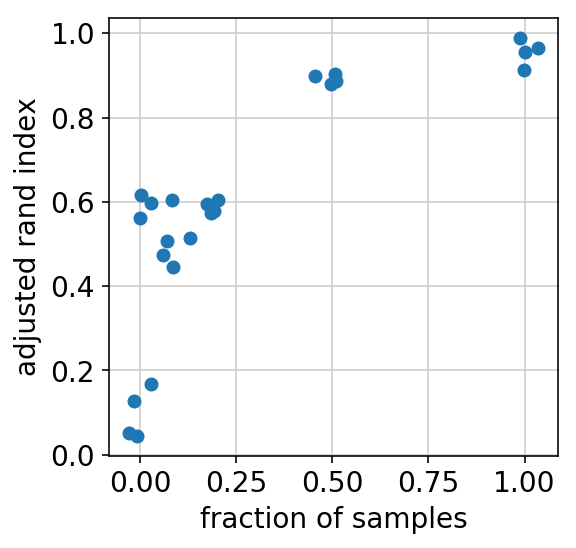

In [8]:
pl.plot(np.array(fractions) + 0.1*(np.random.rand(len(fractions))-0.5), scores_rand, 'o')
pl.ylabel('adjusted rand index')
pl.xlabel('fraction of samples')
pl.show()

#### Our score 

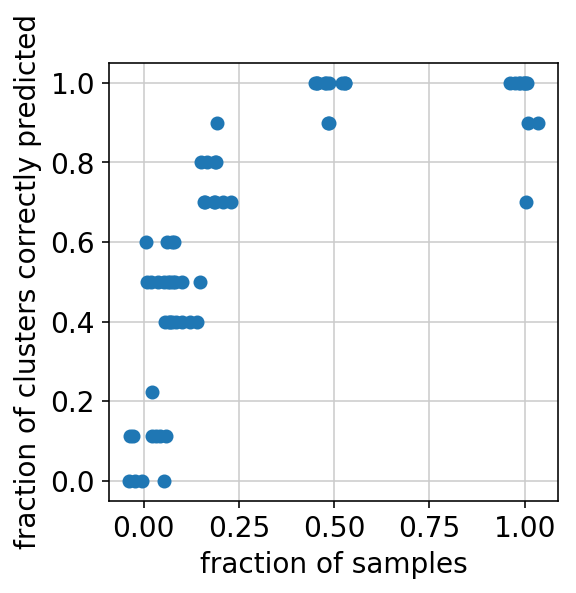

In [5]:
pl.plot(np.array(fractions) + 0.1*(np.random.rand(len(fractions))-0.5), scores, 'o')
pl.ylabel('fraction of clusters correctly predicted')
pl.xlabel('fraction of samples')
pl.show()